# Build the Deep Learning Model and Pipeline

In [1]:

import numpy as np
import pandas as pd
import utils
import tensorflow as tf
import keras

from sklearn.pipeline import Pipeline

from custom_pipelines import FillEmpty, EncodeCategorical, PrepForKeras
from custom_models import make_binary_model
from utils import train_valid_test_split

CONFIG_FILE = "02-01-build-dl-model_config.yml"


2024-02-06 07:30:19.788959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load Notebook Config
config = utils.load_config(CONFIG_FILE)
print(config)

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(123)
    tf.random.set_seed(123)


test_proportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
train_proportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetcontinuous = config['general']['targetcontinuous']
target_col = config['general']['target_col']

features_cat = config['categorical']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# load lists of column categories
col_list = config['categorical']
text_cols = config['text']
continuous_cols = config['continuous']
exclude_cols = config['excluded']


{'general': {'verboseout': True, 'includetext': True, 'presaved': False, 'savemodel': False, 'picklemodel': True, 'save_model_plot': False, 'tensorboard_callback': False, 'hctextmax': 7000, 'maxwords': 6000, 'textmax': 50, 'pickled_data_file': '20142018_0930.pkl', 'pickled_dataframe': '../data/AB_NYC_2019_output_28_sep_2023.pkl', 'modifier': '06_feb_2024', 'targetthresh': 6.0, 'targetcontinuous': False, 'target_col': 'price', 'emptythresh': 6000, 'zero_weight': 1.0, 'one_weight': 45.878, 'one_weight_offset': 0, 'patience_threshold': 3}, 'test_parms': {'testproportion': 0.2, 'trainproportion': 0.8, 'current_experiment': 0, 'repeatable_run': False, 'get_test_train_acc': True}, 'categorical': ['neighbourhood_group', 'neighbourhood', 'room_type'], 'continuous': ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count'], 'text': [], 'excluded': ['price', 'id', 'latitude', 'longitude', 'host_name', 'last_review', 'name', 'host_name', 'availability_365'], '

In [3]:
# Read data
clean_df = pd.read_pickle(config["general"]["pickled_dataframe"])

targetthresh = clean_df[target_col].mean()

In [4]:
# fe = FillEmpty()
# fe.set_params(
#     col_list = col_list, 
#     continuous_cols = continuous_cols,
#     text_cols = text_cols,
#     target_col = target_col,
# )
# fe.fit(clean_df)
# X = fe.transform(clean_df)

In [5]:
pipeline = Pipeline(steps=[("fill_empty", FillEmpty()), ("encode_categorical", EncodeCategorical())])
pipeline.set_params(
    **{
        "fill_empty__col_list": col_list,
        "fill_empty__continuous_cols": continuous_cols,
        "fill_empty__text_cols": text_cols,
        "fill_empty__target_col": target_col,
        "encode_categorical__col_list": col_list,
    }
)

pipeline.fit(clean_df)
X = pipeline.transform(clean_df)

fill empty xform and remove unused columns
fit column:  neighbourhood_group
fit column:  neighbourhood
fit column:  room_type
fill empty xform and remove unused columns
transform column:  neighbourhood_group
after transform column:  neighbourhood_group
transform column:  neighbourhood
after transform column:  neighbourhood
transform column:  room_type
after transform column:  room_type


In [6]:
def prep_target(target_col_values) -> np.array:
    if targetcontinuous:
        return target_col_values.values
    return np.where(target_col_values > targetthresh, 1, 0)

In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = prep_target(dataframe.pop(target_col))
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds




In [8]:
# Split the data
X_train_pre, X_valid_pre, X_test_pre = train_valid_test_split(X, test_prop=test_proportion, train_prop=train_proportion)

train_ds = dataframe_to_dataset(X_train_pre)
val_ds = dataframe_to_dataset(X_valid_pre)
test_ds = dataframe_to_dataset(X_test_pre)

In [9]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'neighbourhood_group': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'neighbourhood': <tf.Tensor: shape=(), dtype=int64, numpy=105>, 'room_type': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'minimum_nights': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'number_of_reviews': <tf.Tensor: shape=(), dtype=int64, numpy=7>, 'reviews_per_month': <tf.Tensor: shape=(), dtype=float64, numpy=2.66>, 'calculated_host_listings_count': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [10]:
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

## Create Model

In [11]:
model = make_binary_model(
    col_list=col_list, 
    continuous_cols=continuous_cols, 
    train_ds=train_ds, 
    loss_func=loss_func,
    output_activation=output_activation,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
)

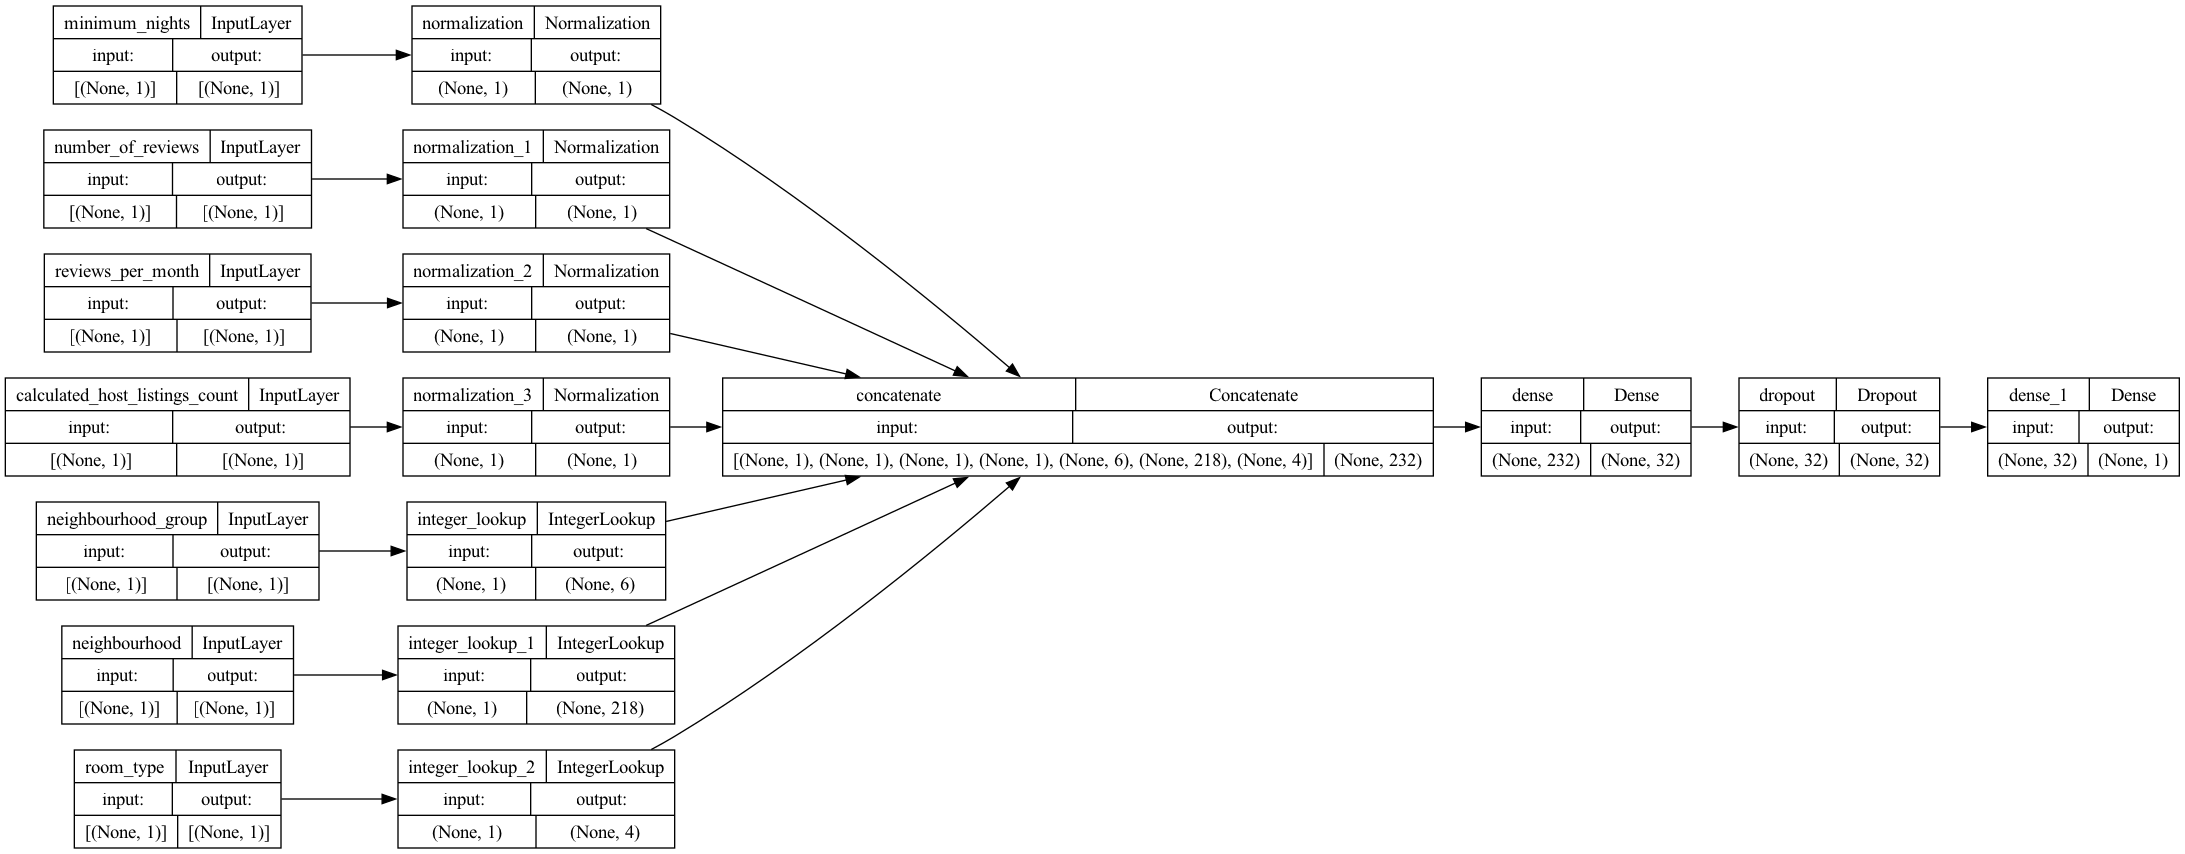

In [12]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [13]:
# Early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=patience_threshold)

checkpoint_filepath = '../checkpoints/' + modifier + '/checkpoint_{epoch:02d}-{val_loss:.2f}.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    options=None,
    save_best_only=True)

## Train Model

In [14]:
model.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[model_checkpoint_callback, es_callback])

Epoch 1/50


313/313 [==============================] - 3s 4ms/step - loss: 0.4898 - accuracy: 0.7633 - val_loss: 0.4462 - val_accuracy: 0.8129
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4422 - accuracy: 0.8054 - val_loss: 0.4329 - val_accuracy: 0.8135
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4288 - accuracy: 0.8080 - val_loss: 0.4251 - val_accuracy: 0.8189
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4262 - accuracy: 0.8092 - val_loss: 0.4209 - val_accuracy: 0.8154
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4204 - accuracy: 0.8087 - val_loss: 0.4248 - val_accuracy: 0.8198
Epoch 6/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.8096 - val_loss: 0.4262 - val_accuracy: 0.8199
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4179 - accuracy: 0.8100 - val_loss: 0.4242 - val_accuracy: 0.8206
Epoch 8/50
313/31